# Multi layer Neural Network With Tensorflow 
### Hichem MAIZA

# Import Libraries  
- First, I import tensorflow: a deep learning framework 
- Second, I import pandas to easily deal with Data frames and csv files 
- Third, I import matplotlib.pyplot to plot figures

In [14]:
import tensorflow as tf
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import math 
from tensorflow.python.framework import ops

# One Hot Encoding Routine :
- The one hot encoding routine is another representation of a class: this technique is used in the case of: the outputs are multiple classes.
- In our case we have 6 classes from 3 to 8 
- An example of one Hot encoding is : 

  <table align="center">
  <tr>
    <th>Class</th>
    <th>One Hot Encoding</th> 
  </tr>
  <tr>
    <td>3</td>
    <td>[1,0,0,0,0,0]</td> 
  </tr>
  <tr>
    <td>4</td>
    <td>[0,1,0,0,0,0]</td> 
  </tr>
  <tr>
    <td>5</td>
    <td>[0,0,1,0,0,0]</td> 
  </tr>
  <tr>
    <td>6</td>
    <td>[0,0,0,1,0,0]</td> 
  </tr>
  <tr>
    <td>7</td>
    <td>[0,0,0,0,1,0]</td> 
  </tr>
  <tr>
    <td>8 and 9</td>
    <td>[0,0,0,0,0,1]</td> 
  </tr>
</table>


- The illustrated function takes as input a vector of labels and compute a one hot matrix as output

In [15]:
def convert_to_onehot(y, nbclass):
    '''
    Creates a Matrix of one hot vector from (Y)
    
    Arguments:
    Y -- input classes, of shape (1, number of examples)
    nbclass -- number of Classes
    
    Returns:
    y_train -- Matrix coded in one hot logic
    '''
    y_train = [] 
    for i in range(len(y)) :
        temp =np.zeros((nbclass))
        # the case of 8 or 9 
        if (y[i] == 9):
            temp[y[i]- 4] = 1
        # other cases
        else : 
            temp[y[i]-3] = 1
        y_train.append(temp)
    return np.array(y_train).T


# Read Data
- This Lab is accompanied with two data sets one for the training and the second for the test 
- I read the Data Sets then I put them in a panda data frames so i can manipulate them easily

In [16]:
train_data = pd.read_csv('winequality_White_train.csv', sep= ';')
train_test = pd.read_csv('winequality_White_test.csv', sep= ';') 

# Features and Labels 
- The data sets are composed of features and labels 
- I put the features in a matrix which i called it X_train 
- I put the labels in a vector which i called it Y_train 
- I also did the same with the test data set

In [17]:
X_train  = (train_data.as_matrix().T)[0:11,:]
X_test = (train_test.as_matrix().T)[0:11,:]
Y_train = convert_to_onehot(train_data['quality'], 6)
Y_test  = convert_to_onehot(train_test['quality'], 6)  

# Shapes !!

- I keep track of shapes, all the times because this is where tensorflow crashes the most 
- In deep learning in general matrix dimensions are so important so here i verify my matrices shapes 
- Note that every column in the X_train matrix is a training sample 
- Note that every column in the Y_train matrix is a training label 
- The same thing with test data sets 

In [18]:
print ("number of training examples = " + str(X_train.shape[1]))
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape)) 

number of training examples = 4398
number of test examples = 500
X_train shape: (11, 4398)
Y_train shape: (6, 4398)
X_test shape: (11, 500)
Y_test shape: (6, 500)


# Batch Vs Mini Batch 

- After one week of research i finally understood what a mini-batch stands for : 
    - We can say that a batch is the hole(complete) data set 
    - And a mini batch is a small portion of it     
- Why this mini batch exist ? and why everyone uses it ? 
    - when we run gradient descent on the whole data set the gradient become too slow to converge 
    - The solution is to decompose the data set into mini-batches so the gradient can converge faster 
- ok ! but what size should we use for this batch
    - 1st case : batch = data set --> case of batch gradient descent (the usual case)
    - 2nd case : batch = one sample--> so we have to iterate all over the exemples (stochastic gradient descent) and its the worst case
        ```python
            for Sample in All_train_Examples:
                Run_Gradient_Descent()
        ```  
    - 3rd case : batch = Not too small and not too big : it can be 32,64,128,256,512 in general $2^n$, the best choice !! 
- There's many methods to compute batches, the one I found it interesting  is to compute mini-batches randomly
- I implemented it in two steps : 
    - The first step is to randomly select sample from X_train and the Corresponding Y_train 
    - The second step is select mini-batches with respect to the bacth size 

In [19]:
def random_batches(X, Y, mini_batch_size = 64, seed = 0) :
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data
    Y -- true "label" vector
    mini_batch_size -- size of the mini-batches
    
    Returns:
    mini_batches -- list of (mini_batch_X, mini_batch_Y)
    """
    
    np.random.seed(seed)            # to get the same result every time so i can verify my results       
    m = X.shape[1]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.d
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:,k*mini_batch_size:k*mini_batch_size + mini_batch_size ]
        mini_batch_Y = shuffled_Y[:,k*mini_batch_size:k*mini_batch_size + mini_batch_size ]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:,num_complete_minibatches*mini_batch_size:]
        mini_batch_Y = shuffled_Y[:,num_complete_minibatches*mini_batch_size:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

# Place holders 
- Tensorflow place holders are variable that can change when the program is running  they are not constant variables 
    - First, I defined X, a place holder for my input features 
    - Second, I defined Y, a place holder for my output labels 
    - The function headers are defined for organizing code and make it more visible 

In [20]:
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- size of features vector
    n_y -- number of classes 
    
    Returns:
    X -- placeholder for the data input
    Y -- placeholder for the input labels
    """
    X = tf.placeholder(dtype = 'float', shape=[n_x, None], name= 'X')
    Y = tf.placeholder(dtype = 'float', shape=[n_y, None], name= 'Y')
    return X, Y

# Architecture !! 
- here I defined my network architecture 
    - First How many layers will this network have ? 
        - This is a deep neural network so I chose to  two hidden layers architecture --> so a 3 layer neural network
    - Second How many neurons the layer has ? 
        - It depends on the number of the layer (you can change the number of neurons and see the result)
        - In this example i chose a 25 neurons in the 1st layer, 12 in the 2nd, and 6 in the 3rd 
    - How i defined shapes ? 
        - I did the calculation by hand, I verify it in hand than i put it into the variables  
    - Xavier ? 
        - After research I found that random initialization is good for weights and zeros initialization for biases to speed up the converging  <br> of the gradient descent, but there are other method more robust for converging, Xavier is one of those methods, the principle is to multiply the random initialization by this Term :  \begin{equation*}\frac{1}{\Bigl(\sqrt{n^(l-1)})} \end{equation*}
        where l is layer number and n is number of features in the training example

In [21]:
def initialize_parameters(name = 'variables'):
    
    """
    Arguments : 
    name -- a tensor borad variable name
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    
    with tf.name_scope(name): 
        
        W1 = tf.get_variable('W1', [25,11], initializer= tf.contrib.layers.xavier_initializer(seed = 1)) 
        b1 = tf.get_variable('b1', [25,1], initializer= tf.zeros_initializer())
        W2 = tf.get_variable('W2', [12,25], initializer= tf.contrib.layers.xavier_initializer(seed = 1))
        b2 = tf.get_variable('b2', [12,1], initializer= tf.zeros_initializer())
        W3 = tf.get_variable('W3', [6,12], initializer= tf.contrib.layers.xavier_initializer(seed = 1))
        b3 = tf.get_variable('b3', [6,1], initializer= tf.zeros_initializer())

        parameters = {"W1": W1,
                      "b1": b1,
                      "W2": W2,
                      "b2": b2,
                      "W3": W3,
                      "b3": b3}

    return parameters

# Tensorflow Graph 

- Here I defined my tensorflow graph which represents the forward pass of my neural network 
- Here I chose to work with the Relu activation Function, why ?? 
    - The Relu activation function is used in cases where the problem is a multi-class classification  
    - The Relu activation function is the most used function in neural network 
- why not sigmoid ? 
    - Sigmoid activation function is used in the case of logictic regression, and usually when the problem is binary classification 

In [26]:
def forward_propagation(X, parameters, name = 'forward_pass'):
    """    
    Arguments:
    X -- input dataset placeholder
    parameters -- python dictionary containing "W1", "b1", "W2", "b2", "W3", "b3"

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    with tf.name_scope(name):
        
        W1 = parameters['W1']
        b1 = parameters['b1']
        W2 = parameters['W2']
        b2 = parameters['b2']
        W3 = parameters['W3']
        b3 = parameters['b3']

        Z1 = tf.add(tf.matmul(W1, X), b1)                                              
        A1 = tf.nn.relu(Z1)                                             
        Z2 = tf.add(tf.matmul(W2, A1), b2)
        A2 = tf.nn.relu(Z2)                                             
        Z3 = tf.add(tf.matmul(W3, A2), b3)                                              
    
    return Z3

# Cost Function 
- Here I defined my cost function 
- We chose to compute a cross entropy cost function, why ? 
    - in cases where we have multi-class classification usually we chose the cross entropy as a cost function 
    - I used Z3 instead of A3 the output of my Forward pass, why ? 
        - This is because tensorflow does the final softmax automatically in other words, if  we are to write our own function, we will 
        do <br>Z3 -- > A3 -- > softmax -- > Cross Entropy, but tensorflow include the softmax function with cross entropy

In [27]:
def compute_cost(Z3, Y, name =  'compute_cost'):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation 
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    with tf.name_scope(name) : 
        
        logits = tf.transpose(Z3)
        labels = tf.transpose(Y)
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))
    
    return cost

# Model !  
- Here I defined my model 
    - First the learning rate: which represents the coefficient when updating the model parameters, it represents one the important hyperparameters 
        - learning_rate = 0.0001 or learning_rate = 0.001 or learning_rate = 0.01 or learning_rate = 0.1 
    - Second the num_epochs : which represent the number times my optimizing process will execute 
        - num_epochs = 500, num_epochs = 1000, num_epochs = 1500, num_epochs = 2000
    - Third the minibatch size: which define the amount of data the algorithm will use at each step of optimization 
- Run the session : 
    - As every neural network, it's necessary to compute for steps 
        - Repeat 
            - Run Forword Pass
            - Compute Cost
            - Run Backword Pass : we don't define it because tensor flow run it for us
                - Run Backword Pass 
                - Update parameters         
- Compute the accuracy of my system 
- Compute the confusion matrix
- Discuss the result 

In [38]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    """
    Arguments:
    X_train -- training set
    Y_train -- training set 
    X_test -- test set 
    Y_test -- test set
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)

    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    with tf.name_scope('train'): 
        optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)    
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3,0), tf.argmax(Y,0))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        #Z3 = forward_propagation(X, parameters)
        pred = tf.argmax(Z3,0)
        original = tf.argmax(Y,0)
        prediction = sess.run(Z3, feed_dict = {X: X_test})
        
        cm = tf.confusion_matrix(original, pred)
        print ("\n the confusion matrix is \n", sess.run(cm, feed_dict = {X: X_test, Y :Y_test }))
        
        # tensor board 
        writer = tf.summary.FileWriter('./train') 
        writer.add_graph(sess.graph)

                
        return parameters

Cost after epoch 0: 7.548606
Cost after epoch 100: 1.269766
Cost after epoch 200: 1.197444
Cost after epoch 300: 1.155308
Cost after epoch 400: 1.129607
Cost after epoch 500: 1.111189
Cost after epoch 600: 1.100523
Cost after epoch 700: 1.093844
Cost after epoch 800: 1.089890
Cost after epoch 900: 1.086204
Cost after epoch 1000: 1.082942
Cost after epoch 1100: 1.084028
Cost after epoch 1200: 1.082413
Cost after epoch 1300: 1.080022
Cost after epoch 1400: 1.078016


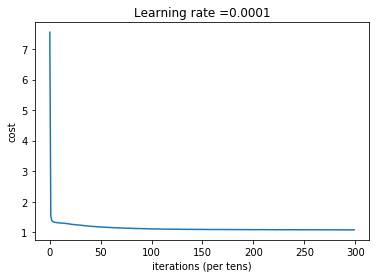

Parameters have been trained!
Test Accuracy: 0.57

 the confusion matrix is 
 [[  1   0   0   0   0   0]
 [  0   2   5   3   0   0]
 [  0   1  61  57   4   0]
 [  0   1  36 193  52   0]
 [  0   0   2  49  28   0]
 [  0   0   0   2   3   0]]


In [39]:
parameters = model(X_train, Y_train, X_test, Y_test)


# Discussion 
- I made a flexible model so i can modify any of its parameters (learning rate, batch size, num of epoch )
- The model has an accuracy of 0.58 (last configuration)
- From the confusion matrix I can conclude that my model didn't detect properly the 8 th class --> 0 true positive detection 
- the class 6 has a 193 true positive detected points 
- my cost function is decreasing so the model is optimizing the cost function